## Paper Notebook

In this notebook we implement an example of the process below.
In order to demonstrate the strength of our approach we simulate the blackbox function and its noise (i.e. the blackbox function becomes a white box function).
This allows us to benchmark different approaches and compare them within a reasonable amount of time and cost.

## Process

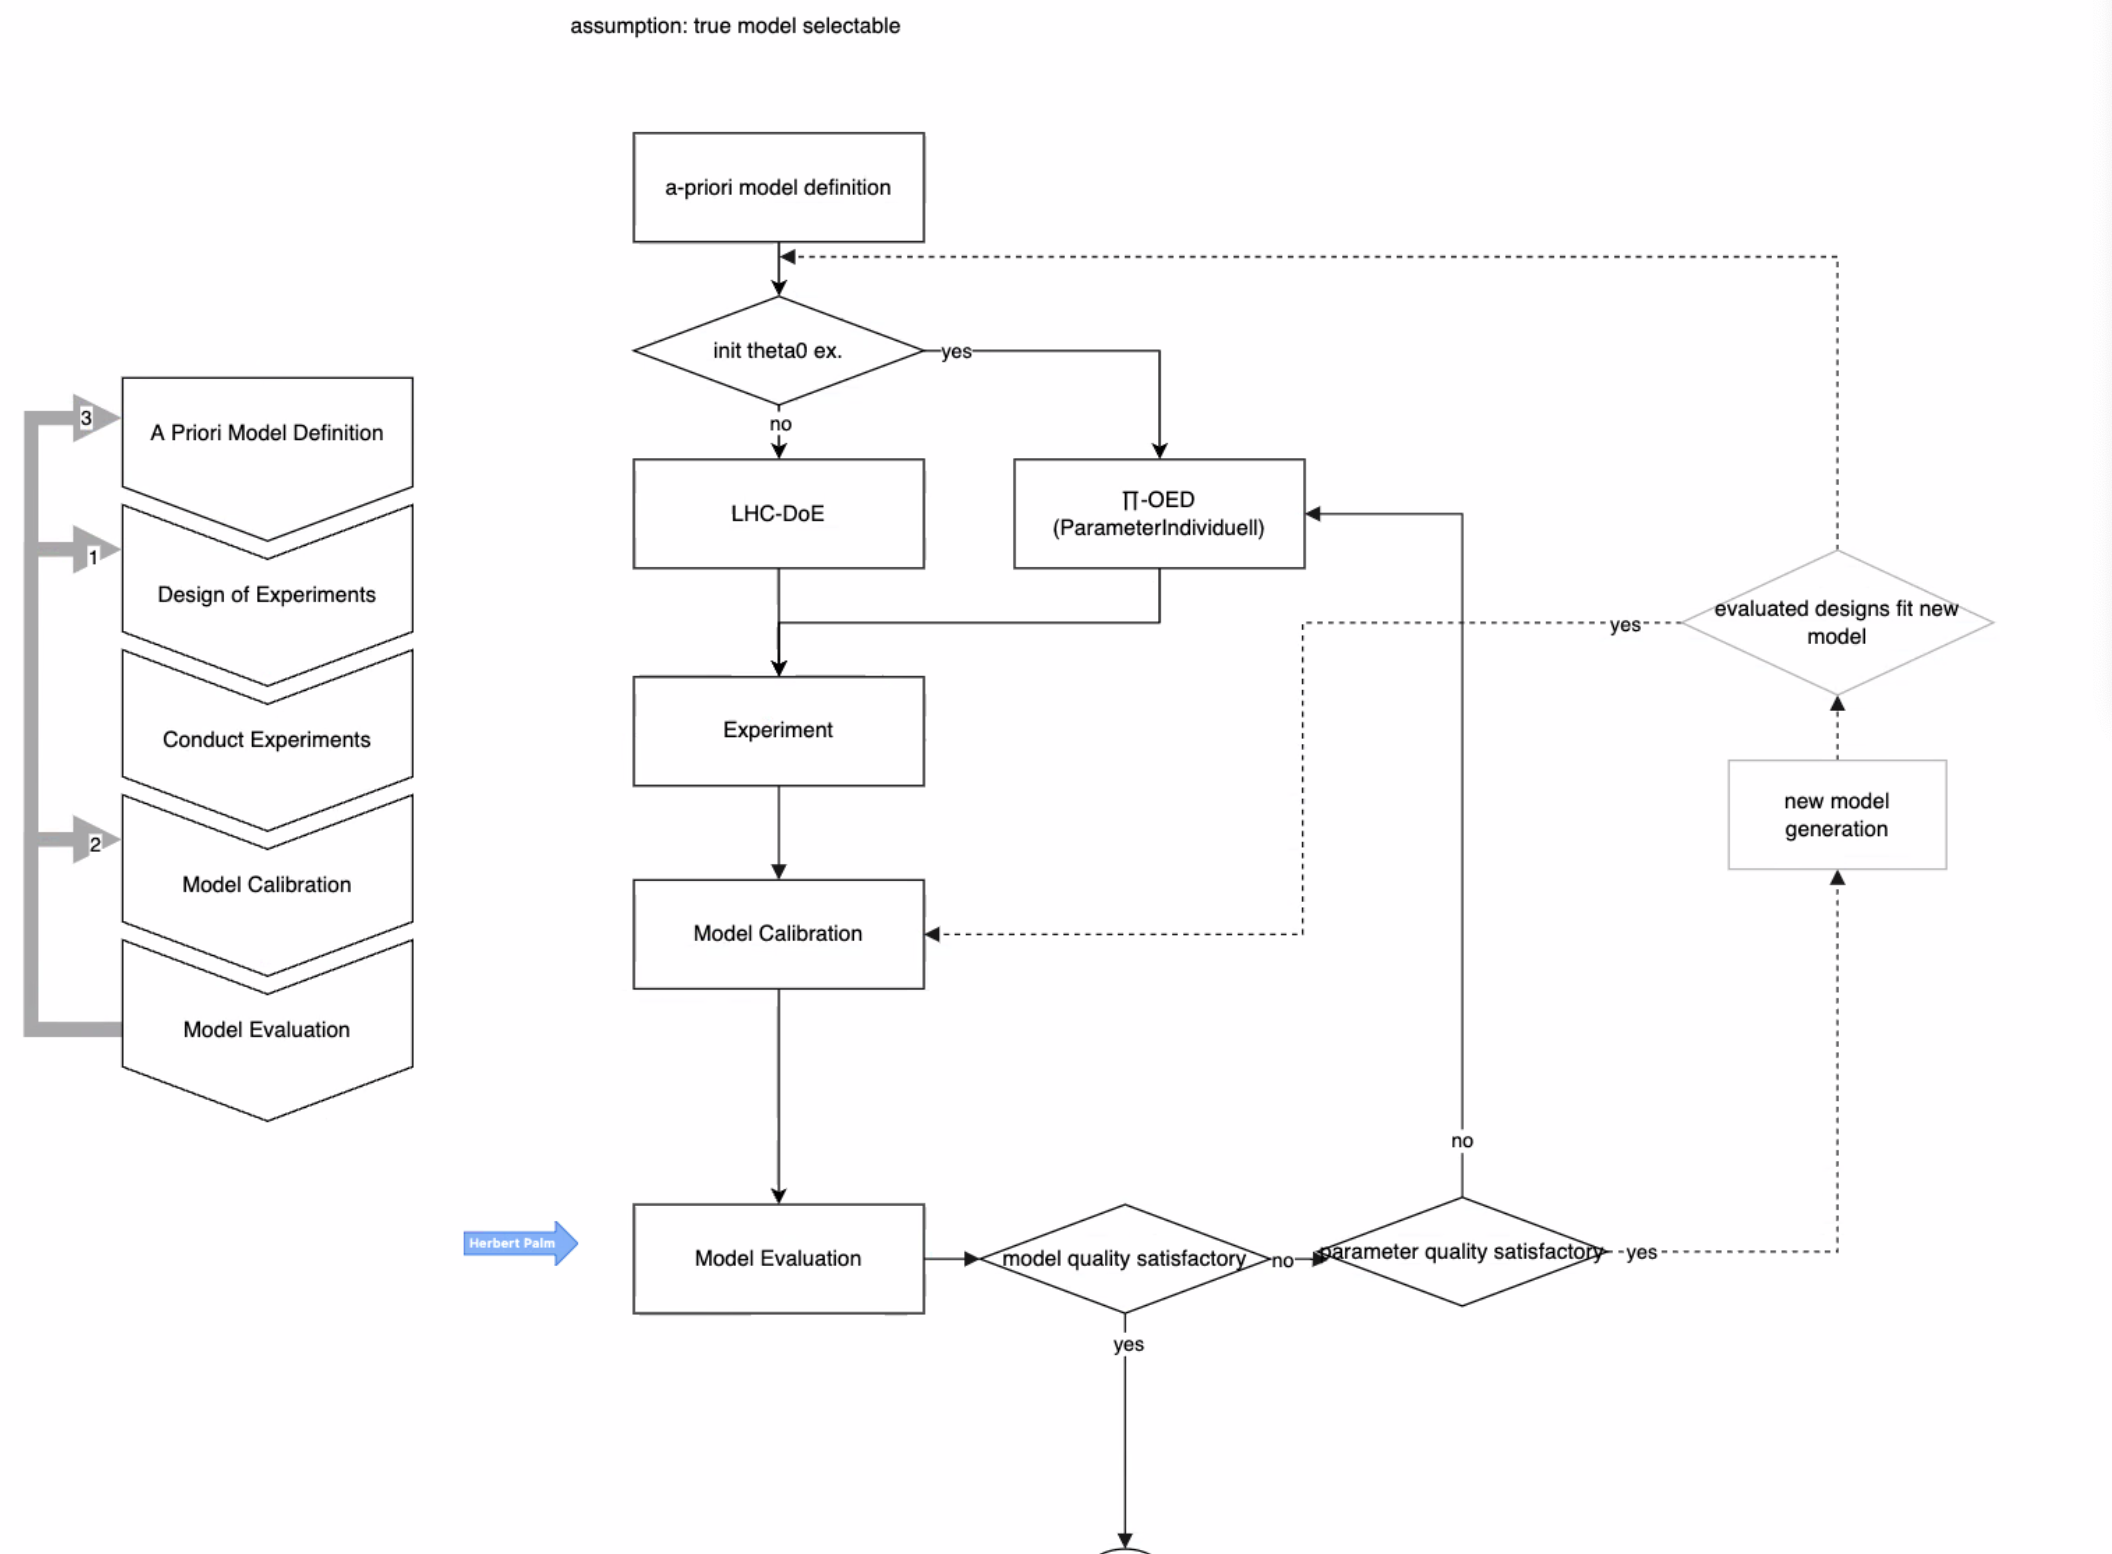

## Importing modules

In [1]:
import os
os.chdir('/Users/nicopalm/Documents/Projects/ode/')
import numpy as np

### Defining minimizer

In [2]:
from src.minimizer.minimizer_library.differential_evolution import DifferentialEvolution

In [3]:
minimizer = DifferentialEvolution()

## A priori model definition

In [4]:
from src.statistical_models.statistical_model_library.gaussian_noise_model import GaussianNoiseModel
from src.parametric_function_library.aging_model_Naumann import AgingModelNaumann

In [5]:
lower_bounds_x = np.array([0.1, 279.15])
upper_bounds_x = np.array([1, 333.15])

lower_bounds_theta = np.array([0.1, 0.1, 0.1])
upper_bounds_theta = np.array([10, 10000, 1])

In [6]:
parametric_function = AgingModelNaumann()

In general, we don't know the amplitude of white noise sigma (i.e. the standard deviation) in our data. However, as seen in ... the resulting experimental designs do not depend on the value of sigma.
A reasonable value in our scenario is given by the below sigma.

In [7]:
sigma = 0.002

In [8]:
statistical_model = GaussianNoiseModel(function=parametric_function, lower_bounds_x=lower_bounds_x,
                                       upper_bounds_x=upper_bounds_x, lower_bounds_theta=lower_bounds_theta,
                                       upper_bounds_theta=upper_bounds_theta, sigma=sigma)

The underlying black box function is given by the Naumann model with theta sepcified below. 

In [9]:
theta = np.array([4, 2300, 0.8])
def blackbox_model(x):
    return statistical_model.random(theta=theta, x=x)

## Design of experiments

We can perform 33 designs in one experiment.

In [10]:
number_designs = 5

We don't have an initial guess for our parameter theta.
Therefore, we perform a Latin hypercube experimental design with 33 experiments and estimate an initial parameter.

### Latin hypercube design

In [11]:
from src.designs_of_experiments.design_library.latin_hypercube import LatinHypercube

In [12]:
LH = LatinHypercube(lower_bounds_design=lower_bounds_x, upper_bounds_design=upper_bounds_x,
                    number_designs=number_designs)

## Initial theta_0 calculation

In [13]:
# plot design points
from src.visualization.plotting_functions import *

In [14]:

data = [dot_scatter(x_dots=LH.design.T[0],
                    y_dots=LH.design.T[1],
                    fill=None)]

fig0 = styled_figure(title=LH.name,data=data,title_x = "State of charge",title_y= "Temperature")
fig0

## Conduct experiments

In [15]:
evaluation_initial_design = np.array([blackbox_model(x) for x in LH.design])

## Model Calibration

### Estimate parameter

In [16]:
initial_theta = statistical_model.calculate_maximum_likelihood_estimation(
    x0=LH.design, y=evaluation_initial_design, minimizer=minimizer)

In [17]:
print("The estimated theta is \n",initial_theta)
print("(Reminder) The real theta is \n",theta)

The estimated theta is 
 [3.39877667e+00 2.13384322e+03 7.73986707e-01]
(Reminder) The real theta is 
 [4.0e+00 2.3e+03 8.0e-01]


## Model Evaluation

(Model accuracy for model validation, CRLB for parameter estimation satisfactory, bootstrapping for asymptotic converegence) 
In order to evaluate the performance of the resulting model (i.e. of the Naumann model with initial theta estimated above) we use the K-fold cross validation approach with 33 folds and error function given by ...

In [18]:
from src.metrics.metric_library.k_fold_cross_validation import KFoldCrossValidation
from src.metrics.error_functions.average_error import AverageError

In [19]:
k_fold_validation = KFoldCrossValidation(
    statistical_model=statistical_model, minimizer=minimizer, error_function=AverageError(),number_splits=number_designs)

### Cross validation

In order to determine the accuracy of the model we use #experiments-fold cross validation.

In [20]:
initial_cross_validation_value = k_fold_validation.calculate(design=LH,evaluations_blackbox_function=evaluation_initial_design)

In [21]:
print(f"The initial 10-fold cross-validation error is {initial_cross_validation_value}")

The initial 10-fold cross-validation error is [0.00234363]


### Check if Fisher information matrix is invertible

In [22]:
det_FI = statistical_model.calculate_determinant_fisher_information_matrix(
    x0=LH.design, theta=initial_theta)
print(
    f"The determinant of the Fisher information matrix at the initial theta and design is \n{det_FI}")

The determinant of the Fisher information matrix at the initial theta and design is 
87.7047073885462


### Cramer Rao lower bound

In order to determine the quality of parameter estimation we consider the Cramer rao lower bound.

In [23]:
from src.designs_of_experiments.design_library.pi_design import PiDesign

In [24]:
print('The cramer rao lower bound at the estimated theta is \n',
      statistical_model.calculate_cramer_rao_lower_bound(x0=LH.design, theta=initial_theta))


The cramer rao lower bound at the estimated theta is 
 [[1.27917017e-01 2.39481369e+01 1.85422220e-03]
 [2.39481369e+01 6.94912454e+03 7.91780860e-01]
 [1.85422220e-03 7.91780860e-01 1.43212631e-04]]


In [25]:
print('The relative expected standard deviations of the parameter estimators are \n', np.sqrt(
    statistical_model.calculate_cramer_rao_lower_bound(x0=LH.design, theta=initial_theta).diagonal())/initial_theta)


The relative expected standard deviations of the parameter estimators are 
 [0.10523048 0.03906632 0.0154617 ]


In [26]:
initial_relative_stds = np.sqrt(
    statistical_model.calculate_cramer_rao_lower_bound(x0=LH.design, theta=initial_theta).diagonal())/initial_theta

In [27]:
import plotly.graph_objects as go

In [28]:
styled_figure(data=[go.Bar(x=[1, 2, 3], y=initial_relative_stds,
              name="initial relative standrad deviations")], 
              title="Relative standard deviation of initial design for each parameter")

## New Design of experiments - Pi design

We are not satisfied with the quality of our parameter selection and in particular with the performance of our model. Therefore, we calculate the Pi-design. There, we can optimize a certain parameter 
We usually choose that parameter which has the highest relative expected error. 
Observe again that this choice is independent of the noise sigma in the data.

In [29]:
parameter = int(input('Which parameter (1,2,3) should be minimized? \n'))-1

Which parameter (1,2,3) should be minimized? 
1


In [30]:
%%time
pi_design = PiDesign(number_designs=number_designs, 
                     lower_bounds_design=lower_bounds_x,
                     upper_bounds_design=upper_bounds_x,
                     column=parameter, 
                     row=parameter, 
                     initial_theta=initial_theta,
                     statistical_model=statistical_model, 
                     previous_design=LH,
                     minimizer=minimizer)

Calculating the Parameter individual design...
finished!

CPU times: user 3min 20s, sys: 235 ms, total: 3min 20s
Wall time: 3min 20s


In [31]:
data = [dot_scatter(x_dots=pi_design.design.T[0][number_designs:]*100,
                    y_dots=pi_design.design.T[1][number_designs:],
                    fill=None)]

fig = styled_figure(title=pi_design.name,data=data,title_x = "State of charge [%]",title_y= "Temperature [K]")
fig

In [32]:
print('The relative expected standard deviations of the initial parameter estimators are \n', np.sqrt(
    statistical_model.calculate_cramer_rao_lower_bound(x0=LH.design, theta=initial_theta).diagonal())/initial_theta)



The relative expected standard deviations of the initial parameter estimators are 
 [0.10523048 0.03906632 0.0154617 ]


In [33]:
print('The relative expected standard deviations of the parameter estimators is now \n', np.sqrt(
    statistical_model.calculate_cramer_rao_lower_bound(x0=pi_design.design, theta=initial_theta).diagonal())/initial_theta)



The relative expected standard deviations of the parameter estimators is now 
 [0.01731994 0.01519832 0.01104721]


In [34]:
optimized_relative_stds = np.sqrt(
    statistical_model.calculate_cramer_rao_lower_bound(x0=pi_design.design, theta=initial_theta).diagonal())/initial_theta

In [35]:
styled_figure(data=[go.Bar(x=[1,2,3],y=initial_relative_stds,name="initial relative standrad deviations"),
                    go.Bar(x=[1,2,3],y=optimized_relative_stds,name="optimized relative standard deviations")],
              title="Relative standard deviations of initial and optimized design for each parameter")

## Conduct new experiments

Observe that the Pi design extends the initial design but we have already evaluated the initial design. We evaluate the blackbox function therefore only at the second have of the pi design.

In [36]:
evaluation_pi_design = np.array([blackbox_model(x) for x in pi_design.design[number_designs:]])

## Estimate new parameters/Model Calibration

In [37]:
optimized_theta = statistical_model.calculate_maximum_likelihood_estimation(
    x0=pi_design.design,
    y=np.concatenate((evaluation_initial_design, evaluation_pi_design),
                     axis=0),
    minimizer=minimizer)

In [38]:
print("The optimized theta is \n",optimized_theta)
print("The real theta is \n",theta)

The optimized theta is 
 [4.05048085e+00 2.27346999e+03 7.92822769e-01]
The real theta is 
 [4.0e+00 2.3e+03 8.0e-01]


In [39]:
print("The initial theta is \n",initial_theta)

The initial theta is 
 [3.39877667e+00 2.13384322e+03 7.73986707e-01]


## New Model evaluation

We evaluate the model with our new parameter and evaluations of the black box function.

### Cross validation

In [40]:
optimized_cross_validation_value = k_fold_validation.calculate(
    design=pi_design, 
    evaluations_blackbox_function=np.concatenate((evaluation_initial_design, evaluation_pi_design), axis=0))

In [41]:
print('The cross validation value of the optimized design is',optimized_cross_validation_value)

The cross validation value of the optimized design is [0.00174159]


In [42]:
print('The initial cross validation value was',initial_cross_validation_value )

The initial cross validation value was [0.00234363]


In [43]:
print(
    'The relative expected standard deviations of the parameter estimators is now \n',
    np.sqrt(
        statistical_model.calculate_cramer_rao_lower_bound(
            x0=pi_design.design, theta=optimized_theta).diagonal()) /
    optimized_theta)

The relative expected standard deviations of the parameter estimators is now 
 [0.01937769 0.014054   0.01074774]


In [44]:
print('The relative expected standard deviations of the parameter estimators was \n', np.sqrt(
    statistical_model.calculate_cramer_rao_lower_bound(x0=LH.design, theta=initial_theta).diagonal())/initial_theta)



The relative expected standard deviations of the parameter estimators was 
 [0.10523048 0.03906632 0.0154617 ]


### Determinant of FI at optimized theta invertible

In [45]:
det_optimized_FI = statistical_model.calculate_determinant_fisher_information_matrix(
    x0=LH.design, theta=optimized_theta)
print(
    f"The determinant of the Fisher information matrix at the optimized theta and design is \n{det_optimized_FI}")

The determinant of the Fisher information matrix at the optimized theta and design is 
44.01307998825545


## Testing/Playground

Compare the estimated thetas and their model at the design points with the real model.

In [46]:
# optimized
np.mean([statistical_model(x=design,theta=theta)-statistical_model(x=design,theta=optimized_theta) for design in pi_design.design])

-0.00015706846726772615

In [47]:
# initial
np.mean([statistical_model(x=design,theta=theta)-statistical_model(x=design,theta=initial_theta) for design in pi_design.design])

0.001235176365993795

## Visualization model

In [48]:
x = pi_design.design[4]
print(f"The design is at state of charge {x[0]*100: .2f}% and temperature {x[1]-273.15: .2f} degree Celsius")

The design is at state of charge  40.84% and temperature  16.71 degree Celsius


In [49]:
statistical_model._function.plot(theta=theta,x=x)


## Benchmarking

### Baseline designs

In [50]:
from src.benchmarking.benchmarking import Benchmarking
from src.designs_of_experiments.design_library.d_design import DDesign
from src.designs_of_experiments.design_library.random import Random

#### Random 

In [51]:
random_design = Random(number_designs=2*number_designs, lower_bounds_design=lower_bounds_x,
                       upper_bounds_design=upper_bounds_x)

#### Latin Hypercube

In [52]:
LH_full = LatinHypercube(lower_bounds_design=lower_bounds_x, upper_bounds_design=upper_bounds_x,
                    number_designs=2*number_designs)

#### D-design

In [53]:
%%time
max_det = DDesign(number_designs=number_designs, 
                  lower_bounds_design=lower_bounds_x,
                  upper_bounds_design=upper_bounds_x, 
                  initial_theta=initial_theta,
                  statistical_model=statistical_model, 
                  previous_design=LH,
                  minimizer=minimizer)

Calculating the Maximum determinant design...
finished!

CPU times: user 3min 11s, sys: 794 ms, total: 3min 12s
Wall time: 3min 12s


### Plotting experimental designs 

In [54]:
from src.visualization.plotting_functions import *
from ipywidgets import interact

In [55]:
experiments=[random_design,LH, pi_design, max_det]

In [56]:
# plot design points
data = [dot_scatter(x_dots=experiments[0].design.T[0],
                    y_dots=experiments[0].design.T[1],fill=None)]
fig0 = go.FigureWidget(data=data)
fig0 = update_layout_of_graph(fig0,
                              title='Design points')

@interact(index=range(len(experiments)))
def update(index='LH'):
    with fig0.batch_update():
        fig0.update_layout(title=experiments[index].name)
        fig0.data[0].x = experiments[index].design.T[0]
        fig0.data[0].y = experiments[index].design.T[1]
        
    return fig0

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3), value=0), Output()), _dom_classes=('…

### Conduct Benchmarking

In [57]:
number_of_evaluations = 1000

In [58]:
benchmarking = Benchmarking(blackbox_model=blackbox_model, statistical_model=statistical_model,
                            designs_of_experiments=experiments)

In [59]:
benchmarking.evaluate_designs(number_of_evaluations=number_of_evaluations, minimizer=minimizer)

Evaluate the Latin Hypercube design: 100%|██| 1000/1000 [03:07<00:00,  5.33it/s]
Evaluate the Parameter individual design: 100%|█| 1000/1000 [04:41<00:00,  3.55i
Evaluate the Maximum determinant design: 100%|█| 1000/1000 [04:51<00:00,  3.43it


In [60]:
benchmarking.plot_estimations()

### Metrics

In [81]:
from src.metrics.metric_library.std_parameter_estimations import StdParameterEstimations
from src.metrics.metric_library.determinant_of_fisher_information_matrix import DeterminantOfFisherInformationMatrix
from src.metrics.metric_library.estimation_mean_error import EstimationMeanError
from src.metrics.metric_library.estimation_mean_parameter_estimations import EstimationMeanParameterEstimations
from src.metrics.metric_library.estimation_variance_parameter_estimations import EstimationVarianceParameterEstimations

#### Determinant

In [62]:
det_metric = DeterminantOfFisherInformationMatrix(theta=theta, statistical_model=statistical_model)

In [63]:
fig = det_metric.plot(
    evaluations_blackbox_function_for_each_design=benchmarking.evaluations_blackbox_function,
    estimations_of_parameter_for_each_design=benchmarking.maximum_likelihood_estimations,
    baseline="max",
)
fig.show()

#### Mean

In [64]:
estimation_mean_parameter_estimation=EstimationMeanParameterEstimations()

In [75]:
estimation_mean_parameter_estimation.plot(
    evaluations_blackbox_function_for_each_design=benchmarking.evaluations_blackbox_function,
    estimations_of_parameter_for_each_design=benchmarking.maximum_likelihood_estimations,
    baseline=theta,
)

#### Standard deviations

In [82]:
std_parameter_estimation = StdParameterEstimations()

##### ...at real parameter

In [83]:
baseline = np.sqrt(np.array([statistical_model.calculate_cramer_rao_lower_bound(
    x0=design.design, theta=theta).diagonal() for design in experiments]).T)

std_parameter_estimation.plot(
    evaluations_blackbox_function_for_each_design=benchmarking.evaluations_blackbox_function,
    estimations_of_parameter_for_each_design=benchmarking.maximum_likelihood_estimations,
    baseline=baseline,
)

##### ...at initial parameter 

In [84]:
baseline = np.sqrt(np.array([statistical_model.calculate_cramer_rao_lower_bound(
    x0=design.design, theta=initial_theta).diagonal() for design in experiments]).T)

std_parameter_estimation.plot(
    evaluations_blackbox_function_for_each_design=benchmarking.evaluations_blackbox_function,
    estimations_of_parameter_for_each_design=benchmarking.maximum_likelihood_estimations,
    baseline=baseline,
)

In [74]:
# FI at REAL Theta
from scipy.stats import norm
from plotly.subplots import make_subplots

i = 0
x = benchmarking.maximum_likelihood_estimations[benchmarking.designs[0]].T[i].T

CRLB_at_theta = statistical_model.calculate_cramer_rao_lower_bound(x0=LH.design, theta=theta).diagonal()
data = [go.Histogram(x=x,
                    xbins=dict( # bins used for histogram
                    start=3,
                    end=5.5,
                    size=0.05),
                    opacity= 0.7,
                    histnorm='percent',
                    ),
        go.Scatter(x=np.arange(3,5.5,0.01),y=norm.pdf(x=np.arange(3,5.5,0.01),loc=theta[i],scale = CRLB_at_theta[i]))
       ]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(data[0])
fig.add_trace(data[1],secondary_y=True)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
fig.update_yaxes(title_text="<b>Fraction of in [%]</b>",secondary_y=False)